In [49]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import copy

import scipy
import scipy.integrate as integrate

import numpy as np 

from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table, Column, vstack

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import sedpy
import extinction

In [6]:
from sedpy import observate
from sedpy import reference_spectra

In [4]:
extinction_coeffs_hsc = {
    "HSC-G": 3.240,
    "HSC-R": 2.276,
    "HSC-I": 1.633,
    "HSC-Z": 1.263,
    "HSC-Y": 1.075,
    "NB0387": 4.007,
    "NB0816": 1.458,
    "NB0921": 1.187,
}

#### DECam Calibration

In [204]:
decam_rb = [3.994, 3.212, 2.164, 1.591, 1.211, 1.063]
decam_filters = ['decam_u', 'decam_g', 'decam_r', 'decam_i', 'decam_z', 'decam_y']

In [ ]:
sdss_rb = [4.239, 3.303, ]

#### Reference spectra of synthetic stars

- Following Schlafly & Finkbeiner (2011):
    - "For the source spectrum, we use for S(λ) a synthetic spectrum from [Munari et al. (2005)](https://www.aanda.org/articles/aa/pdf/2005/42/aa2490-04.pdf), with Teff = 7000 K, logZ = −1, and log g = 4.5."

In [208]:
star_ref = Table.read('../../data/stellar/munari2005_t7000_g45_m10.txt', format='ascii')

star_wave, star_flux = star_ref['col1'], star_ref['col2']

- extinction = E(B-V) x Coefficient.

- https://github.com/schlafly/dust/blob/master/python/dust.py
- https://github.com/schlafly/specfilt

In [175]:
solar = reference_spectra.solar

solar_wave, solar_flux = solar[:, 0], solar[:, 1]

flag = (solar_wave >= 2800.) & (solar_wave <= 11000)
solar_wave, solar_flux = solar_wave[flag], solar_flux[flag]

In [223]:
decam_r = observate.Filter("decam_g")
decam_r_wave, decam_r_curve = decam_r.wavelength, decam_r.transmission

In [224]:
decam_r.ab_mag(star_wave, star_flux)

-37.92702654710964

In [251]:
#ext = extinction.fitzpatrick99(star_wave.astype(np.float64), 1.0, 3.1)
ext = af99(star_wave, rv=3.1)

In [279]:
star_flux_ext = star_flux * 10.0 ** (-0.4 * ext)

In [280]:
#star_flux_ext = extinction.apply(
#    extinction.fitzpatrick99(star_wave.astype(np.float64), 0.78, 3.1), star_flux)

In [281]:
decam_r.ab_mag(star_wave, star_flux_ext) - decam_r.ab_mag(star_wave, star_flux)

3.0780694979556813

In [272]:
compute_rf(star_wave, star_flux, decam_r_wave, decam_r_curve, 0.78/3.1, 
           divide_by_av=True, reddeninglaw=af99, deriv=False)

3.114828635996208

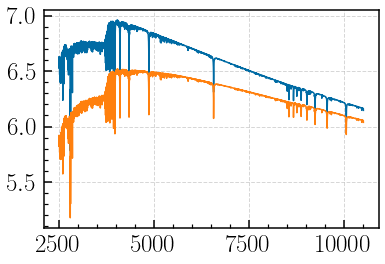

In [219]:
plt.plot(star_wave, np.log10(star_flux))
plt.plot(star_wave, np.log10(star_flux_ext))

In [267]:
def fm_unred(wave, flux, ebv, *args, **kwargs):
    '''
    NAME:
     FM_UNRED
    PURPOSE:
     Deredden a flux vector using the Fitzpatrick (1999) parameterization
    EXPLANATION:
     The R-dependent Galactic extinction curve is that of Fitzpatrick & Massa
     (Fitzpatrick, 1999, PASP, 111, 63; astro-ph/9809387 ).
     Parameterization is valid from the IR to the far-UV (3.5 microns to 0.1
     microns).  UV extinction curve is extrapolated down to 912 Angstroms.
    CALLING SEQUENCE:
     fm_unred( wave, flux, ebv [, 'LMC2', 'AVGLMC', 'ExtCurve', R_V = ,
                                   gamma =, x0=, c1=, c2=, c3=, c4= ])
    INPUT:
      wave - wavelength vector (Angstroms)
      flux - calibrated flux vector, same number of elements as "wave"
      ebv  - color excess E(B-V), scalar.  If a negative "ebv" is supplied,
              then fluxes will be reddened rather than dereddened.
    OUTPUT:
      Unreddened flux vector, same units and number of elements as "flux"
    OPTIONAL INPUT KEYWORDS
      R_V - scalar specifying the ratio of total to selective extinction
               R(V) = A(V) / E(B - V).  If not specified, then R = 3.1
               Extreme values of R(V) range from 2.3 to 5.3
      'AVGLMC' - if set, then the default fit parameters c1,c2,c3,c4,gamma,x0
             are set to the average values determined for reddening in the
             general Large Magellanic Cloud (LMC) field by Misselt et al.
            (1999, ApJ, 515, 128)
      'LMC2' - if set, then the fit parameters are set to the values determined
             for the LMC2 field (including 30 Dor) by Misselt et al.
             Note that neither /AVGLMC or /LMC2 will alter the default value
             of R_V which is poorly known for the LMC.
      The following five input keyword parameters allow the user to customize
      the adopted extinction curve.  For example, see Clayton et al. (2003,
      ApJ, 588, 871) for examples of these parameters in different interstellar
      environments.
      x0 - Centroid of 2200 A bump in microns (default = 4.596)
      gamma - Width of 2200 A bump in microns (default = 0.99)
      c3 - Strength of the 2200 A bump (default = 3.23)
      c4 - FUV curvature (default = 0.41)
      c2 - Slope of the linear UV extinction component
           (default = -0.824 + 4.717 / R)
      c1 - Intercept of the linear UV extinction component
           (default = 2.030 - 3.007 * c2)
    OPTIONAL OUTPUT KEYWORD:
      'ExtCurve' - If this keyword is set, fm_unred will return two arrays.
                  First array is the unreddend flux vector.  Second array is
                  the E(wave-V)/E(B-V) extinction curve, interpolated onto the
                  input wavelength vector.
    EXAMPLE:
       Determine how a flat spectrum (in wavelength) between 1200 A and 3200 A
       is altered by a reddening of E(B-V) = 0.1.  Assume an "average"
       reddening for the diffuse interstellar medium (R(V) = 3.1)
       >>> w = 1200 + arange(40)*50       #Create a wavelength vector
       >>> f = w*0 + 1                    #Create a "flat" flux vector
       >>> fnew = fm_unred(w, f, -0.1)    #Redden (negative E(B-V)) flux vector
       >>> plot(w, fnew)
    NOTES:
       (1) The following comparisons between the FM curve and that of Cardelli,
           Clayton, & Mathis (1989), (see ccm_unred.pro):
           (a) - In the UV, the FM and CCM curves are similar for R < 4.0, but
                 diverge for larger R
           (b) - In the optical region, the FM more closely matches the
                 monochromatic extinction, especially near the R band.
       (2)  Many sightlines with peculiar ultraviolet interstellar extinction
               can be represented with the FM curve, if the proper value of
               R(V) is supplied.
    REQUIRED MODULES:
       scipy, np
    REVISION HISTORY:
       Written   W. Landsman        Raytheon  STX   October, 1998
       Based on FMRCurve by E. Fitzpatrick (Villanova)
       Added /LMC2 and /AVGLMC keywords,  W. Landsman   August 2000
       Added ExtCurve keyword, J. Wm. Parker   August 2000
       Assume since V5.4 use COMPLEMENT to WHERE  W. Landsman April 2006
       Ported to Python, C. Theissen August 2012
    '''

    from scipy.interpolate import CubicSpline

    lmc2_set, avglmc_set, extcurve_set = None, None, None
    R_V, gamma, x0, c1, c2, c3, c4 = None, None, None, None, None, None, None

    x = 10000. / np.array([wave])  # Convert to inverse microns
    curve = x * 0.

    for arg in args:
        if arg.lower() == 'lmc2':
            lmc2_set = 1
        if arg.lower() == 'avglmc':
            avglmc_set = 1
        if arg.lower() == 'extcurve':
            extcurve_set = 1

    for key in kwargs:
        if key.lower() == 'r_v':
            R_V = kwargs[key]
        if key.lower() == 'x0':
            x0 = kwargs[key]
        if key.lower() == 'gamma':
            gamma = kwargs[key]
        if key.lower() == 'c4':
            c4 = kwargs[key]
        if key.lower() == 'c3':
            c3 = kwargs[key]
        if key.lower() == 'c2':
            c2 = kwargs[key]
        if key.lower() == 'c1':
            c1 = kwargs[key]

    if R_V == None:
        R_V = 3.1

    if lmc2_set == 1:
        if x0 == None: x0 = 4.626
        if gamma == None: gamma =  1.05
        if c4 == None: c4 = 0.42   
        if c3 == None: c3 = 1.92
        if c2 == None: c2 = 1.31
        if c1 == None: c1 = -2.16
    elif avglmc_set == 1:
        if x0 == None: x0 = 4.596  
        if gamma == None: gamma = 0.91
        if c4 == None: c4 = 0.64  
        if c3 == None: c3 =  2.73
        if c2 == None: c2 = 1.11
        if c1 == None: c1 = -1.28
    else:
        if x0 == None: x0 = 4.596  
        if gamma == None: gamma = 0.99
        if c4 == None: c4 = 0.41
        if c3 == None: c3 =  3.23
        if c2 == None: c2 = -0.824 + 4.717 / R_V
        if c1 == None: c1 = 2.030 - 3.007 * c2
    
    # Compute UV portion of A(lambda)/E(B-V) curve using FM fitting function and 
    # R-dependent coefficients
 
    xcutuv = 10000.0 / 2700.0
    xspluv = 10000.0 / np.array([2700.0, 2600.0])
   
    iuv = x >= xcutuv
    iuv_comp = ~iuv

    if len(x[iuv]) > 0: xuv = np.concatenate( (xspluv, x[iuv]) )
    else: xuv = xspluv.copy()

    yuv = c1  + c2 * xuv
    yuv = yuv + c3 * xuv**2 / ( ( xuv**2 - x0**2 )**2 + ( xuv * gamma )**2 )

    filter1 = xuv.copy()
    filter1[xuv <= 5.9] = 5.9
    
    yuv = yuv + c4 * ( 0.5392 * ( filter1 - 5.9 )**2 + 0.05644 * ( filter1 - 5.9 )**3 )
    yuv = yuv + R_V
    yspluv = yuv[0:2].copy()                  # save spline points
    
    if len(x[iuv]) > 0: curve[iuv] = yuv[2:len(yuv)]      # remove spline points

    # Compute optical portion of A(lambda)/E(B-V) curve
    # using cubic spline anchored in UV, optical, and IR

    xsplopir = np.concatenate(([0], 10000.0 / np.array([26500.0, 12200.0, 6000.0, 5470.0, 4670.0, 4110.0])))
    ysplir   = np.array([0.0, 0.26469, 0.82925]) * R_V / 3.1
    ysplop   = [np.polyval(np.array([2.13572e-04, 1.00270, -4.22809e-01]), R_V ), 
                np.polyval(np.array([-7.35778e-05, 1.00216, -5.13540e-02]), R_V ),
                np.polyval(np.array([-3.32598e-05, 1.00184, 7.00127e-01]), R_V ),
                np.polyval(np.array([-4.45636e-05, 7.97809e-04, -5.46959e-03, 1.01707, 1.19456] ), R_V ) ]
    
    ysplopir = np.concatenate( (ysplir, ysplop) )
    
    if len(iuv_comp) > 0:
        cubic = CubicSpline(np.concatenate( (xsplopir,xspluv) ),
                            np.concatenate( (ysplopir,yspluv) ), bc_type='natural')
        curve[iuv_comp] = cubic( x[iuv_comp] )

    # Now apply extinction correction to input flux vector
    curve = ebv * curve[0]
    flux = flux * 10.**(0.4 * curve)
    if extcurve_set is None:
        return flux
    else:
        ExtCurve = curve/ebv - R_V
        return flux, ExtCurve

    
def af99(lam, rv=3.1):
    """Return A(lam) from F99
    Returns the extinction A(lam) at wavelength lam (angstroms) from the
    Fitzpatrick (1999) prescription.  A(lam) is normalized to 1 at 5420 A
    (~V).  Note this normalization is arbitrary!
    Args:
        lam: wavelengths at which A(lam) should be evaluated, angstroms
        rv: R_V parameter of the reddening curve
    Returns:
        A(lam, rv)/A(5420 A, rv)
    """
    lam = np.atleast_1d(lam)

    flux = np.ones_like(lam)
    rflux = fm_unred(lam, flux, -1./rv, R_V=rv)
    ext = -2.5*np.log10(rflux/flux)
    ext_1micron = -2.5 * np.log10(fm_unred(10000., 1, -1./rv, R_V=rv))
    return ext / ext_1micron


def compute_rf(ws, ss, wf, sf, av, divide_by_av=True, urmag=None,
               reddeninglaw=af99, deriv=False, atm=1., **kw):
    """Return A_f/E(B-V) for a given spectrum and filter from F99
    Returns the extinction at A_V in a given filter
    (wf, sf) for a given spectrum (ws, ss).  An F99 reddening law with
    given R_V is assumed.
    Args:
        ws: wavelength (angstroms) at which spectrum is tabulated
        ss: flux (energy/unit wavelength/unit time/unit area)
        wf: wavelength (angstroms) at which filter is tabulated
        sf: filter throughput (probability a photon is registered)
        av: the dust column of interest, units A_5420 (mag)
        divide_by_av: flag indicating whether or not A_f should be
                       normalized to A_V
        **kw: extra parameters to pass to reddening law
    Returns:
        A_filter/A_V
    """
    if urmag is None and not deriv:
        urmag = intfilter(ws, ss, wf, sf, atm=atm)
    extmag = reddeninglaw(ws, **kw)*av
    med_extmag = np.median(extmag)
    extmag -= med_extmag  # get rid of gray component; add back in below
    # makes the algorithm somewhat more robust against underflow
    ssr = ss*10.**(-0.4 * extmag)
    rmag = intfilter(ws, ssr, wf, sf)+med_extmag
    if deriv:
        eps = 0.001
        extmag += med_extmag
        extmag *= (1 + eps/av)
        med_extmag = np.median(extmag)
        extmag -= med_extmag
        ssr = ss*10.**(-extmag/2.5)
        urmag = intfilter(ws, ssr, wf, sf, atm=atm)+med_extmag
    res = rmag-urmag
    if divide_by_av and not deriv:
        res /= av
    if deriv:
        res /= (-eps)
    return res

def intfilter(ws, ss, wf, sf, wa=None, sa=None, atm=1.):
    """Return AB magnitude corresponding to filter and atmosphere (photon
    counting).
    Args:
        ws, ss: wavelength (A) and spectrum (erg/cm^2/s/A) of the source
        wf, sf: wavelength (A) and QE (0-1) of the filter
        wa, sa: wavelength (A) and transparency (0-1) of the atmosphere
                (optional)
        atm: airmass to use
        ws, wf, wa must be sorted by wavelengeth
    Returns:
        the AB magnitude of the source in the filter
    """

    if wa is None:
        wa = ws
        sa = np.ones(len(ws))

    if atm != 1:
        sa = sa ** atm

    wall = np.unique(np.concatenate([ws, wf, wa]))
    ssall = np.interp(wall, ws, ss)
    sfall = np.interp(wall, wf, sf, left=0., right=0.)
    saall = np.interp(wall, ws, sa)
    sfall *= saall

    h = 6.62606957e-27  # erg * s
    c = 2.99792458e10  # cm/s
    flux_to_number = h*c/(wall*1e-8)  # 1e8 Angstrom / cm

    def integrator(x, y):
        return integrate.trapz(x, y)

    flux = integrator(sfall*ssall/flux_to_number, wall)

    szall = 3631e-23*c/wall/(wall*1e-8)
    zflux = integrator(sfall*szall/flux_to_number, wall)

    if (flux <= 0) or (zflux <= 0):
        raise ValueError('flux and zero flux must be > 0')

    return -2.5*np.log10(flux / zflux)